The purpose of this notebook is to walk through the `binaryClassification2.py` module and show what has been changed in the implementation of the binary classification supervised cadre model.

The summary:

* Cross-entropy is now used as loss. This means that sigmoided prediction scores should function as well-calibrated probabilities
* As a consequence of the above, target values should now take values of 0 and 1 instead of -1 and +1.
* Data should now be supplied as a `pandas.DataFrame` object instead of as `numpy.array`s. This change makes it easier to work with heterogeneous datasets in which not every column has a predictive meaning.
* You may now explicitly choose what features are used for cadre-assignment and what features are used for target-prediction.
* Parameters (`W`, `W0`, `d`, `C`) are now returned as `pandas.DataFrame` and `pandas.Series` objects. This makes results easier to understand -- when you do, e.g. `print(W)`, you see what feature each weight is associated with.
* A wider variety of model quality metrics are evaluated during and after training. Currently, loss, accuracy, `average_precision_score`, and `roc_auc_score` are used. These are returned in easy-to-interpret `pandas.DataFrame` objects after training.
* Periodically during training, the proportions of the training set belonging to each cadre are calculated. This lets you see if the model is converging to a stable cadre structure, or if cadre assignments are very noisy.

Most other components are unchanged. So, for example, scripts used for hyperparameter tuning should still work.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from scipy.stats import zscore, zmap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.insert(0, '../cadreModels/')
from classificationBinary2 import binaryCadreModel

Load `breast_cancer` and combine observations, labels, and feature names into a single `pd.DataFrame`

In [3]:
breast_cancer = load_breast_cancer()
data = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names']).assign(target=breast_cancer['target'])
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Perform randomized train-test split

In [4]:
Dtr, Dva = train_test_split(data, test_size=0.2, random_state=1515)
Dtr.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
230,17.05,19.08,113.40,895.0,0.11410,0.15720,0.19100,0.10900,0.2131,0.06325,...,24.89,133.50,1189.0,0.1703,0.3934,0.50180,0.25430,0.3109,0.09061,0
469,11.62,18.18,76.38,408.8,0.11750,0.14830,0.10200,0.05564,0.1957,0.07255,...,25.40,88.14,528.1,0.1780,0.2878,0.31860,0.14160,0.2660,0.09270,1
131,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,...,26.00,124.90,1156.0,0.1546,0.2394,0.37910,0.15140,0.2837,0.08019,0
418,12.70,12.17,80.88,495.0,0.08785,0.05794,0.02360,0.02402,0.1583,0.06275,...,16.92,88.12,566.9,0.1314,0.1607,0.09385,0.08224,0.2775,0.09464,1
288,11.26,19.96,73.72,394.1,0.08020,0.11810,0.09274,0.05588,0.2595,0.06233,...,22.33,78.27,437.6,0.1028,0.1843,0.15460,0.09314,0.2955,0.07009,1


Now we're going to choose features. For sake of argument, any feature that is a `mean` measurement will be used only for cadre-assignment, and any feature that is a `worst` measurement will be used only for target-prediction. This choice is just meant to show that the cadre-assignment and target-prediction feature sets may be different.

If `Pcadre` is the number of features used for cadre-assignment and `M` is the number of cadres, then the cadre-center parameter `C` is `Pcadre x M` in size.

If `Ppredict` is the number of features used for target-prediction and `M` is the number of cadres, then the classification weight parameter `W` is `Ppredict x M` in size.

If you wanted to, you could treat `Pcadre` and `Ppredict` as hyperparameters and tune them. But in practice, we use domain knowledge to choose them.

In [5]:
cadreFts = data.columns[data.columns.str.contains('mean')]
predictFts = data.columns[data.columns.str.contains('worst')]

In [6]:
print(cadreFts)

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension'],
      dtype='object')


In [7]:
print(predictFts)

Index(['worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')


Standardize training and validation sets

In [8]:
features = cadreFts.union(predictFts)

In [9]:
Dva[features] = zmap(Dva[features].values, Dtr[features].values)
Dtr[features] = zscore(Dtr[features].values)

/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [10]:
Dva.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
164,2.672402,0.667354,2.550524,3.105200,-0.857971,0.175065,0.585192,1.263230,-0.047520,-1.046939,...,0.429451,2.345493,2.794007,-0.420938,0.665216,0.635083,1.833745,1.071737,0.459983,0
456,-0.711585,2.413538,-0.707957,-0.697209,-0.208354,-0.365088,-0.206901,-0.748526,-0.054716,-0.187139,...,2.188588,-0.630760,-0.624920,0.362743,-0.327452,0.127080,-0.701244,-0.036830,-0.669402,1
420,-0.729028,-0.055206,-0.736226,-0.713366,-0.782253,-0.525105,-0.425117,-0.902713,0.780066,-0.045475,...,0.223471,-0.618935,-0.638229,-0.328482,-0.387575,-0.052827,-0.727319,0.200608,-0.058489,1
149,-0.098165,-0.327370,-0.148914,-0.188885,-1.208254,-0.777903,-0.764363,-0.928629,-1.227729,-1.009069,...,-0.527359,-0.292687,-0.263737,-1.551993,-0.459850,-0.546456,-0.825669,-0.876510,-0.787680,1
193,-0.505173,1.828265,-0.442992,-0.510814,0.487260,0.565718,0.273827,-0.082304,0.463424,0.894273,...,2.276628,-0.155942,-0.185338,2.031369,1.383493,0.871490,0.481243,0.483646,2.103821,0


Define and train SCM model object. We're not going to tune any hyperparameters here. Note that we now supply the `binaryCadreModel` object with the cadre-assignment features and target-prediction features, as well as the name of the target feature.

If we did not supply any `cadreFts` or `targetFts`, they default to being every column in `data` other than `targetCol`.

In [11]:
scm = binaryCadreModel(M=5, Tmax=1001, record=10)
scm.fit(data=Dtr,
       targetCol='target',
       cadreFts=cadreFts,
       predictFts=predictFts,
       dataVa=Dva,
       progress=True)

0
10 0.9011193 0.3010989010989011 0.8982113 0.2982456140350877 0.11791753768920898
20 0.8254713 0.6285714285714286 0.82058704 0.6842105263157895 1.3872568607330322
30 0.7617282 0.8637362637362638 0.7547534 0.9122807017543859 1.6487541198730469
40 0.70944405 0.9296703296703297 0.7011222 0.9824561403508771 1.8897154331207275
50 0.666099 0.945054945054945 0.6566064 0.9824561403508771 2.136929988861084
60 0.62952733 0.9406593406593406 0.618661 0.9824561403508771 2.392932653427124
70 0.6006447 0.945054945054945 0.58769417 0.9824561403508771 2.6590726375579834
80 0.5762556 0.9494505494505494 0.56101906 0.9824561403508771 2.9050133228302
90 0.55563253 0.9516483516483516 0.5386152 0.9824561403508771 3.1531457901000977
100 0.538546 0.9516483516483516 0.52027553 0.9824561403508771 3.423999547958374
110 0.52380997 0.9516483516483516 0.5040145 0.9824561403508771 3.6742610931396484
120 0.51093227 0.9516483516483516 0.4899943 0.9824561403508771 3.9092743396759033
130 0.49921054 0.9516483516483516 0.

The `metrics` attribute of `scm` contains training and validation metrics values. We can plot them separately. `ROC_AUC` is the receiver operator characteristic area under the curve (`sklearn.metrics.roc_auc_score`). `PR_AUC` is the average precision, i.e., area under the precision-recall curve (`sklearn.metrics.average_precision_score`).

The x-axis in these plots dependent on iteration count.

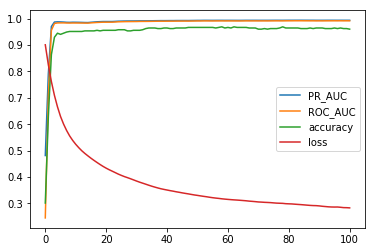

In [12]:
scm.metrics['training'].plot()

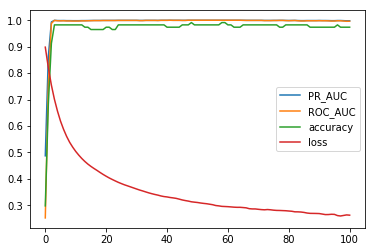

In [13]:
scm.metrics['validation'].plot()

Model parameters are stored as `pd.DataFrame` objects.

In [14]:
scm.W

,0,1,2,3,4
worst radius,-0.000109,-0.000036,0.000000,-0.403995,-0.821283
worst texture,-0.530622,0.000043,-0.000061,-0.262894,-0.385732
worst perimeter,-0.000044,-0.000000,-0.000165,-0.468529,-0.568694
worst area,0.000048,0.000034,0.000323,-0.482038,-0.755172
worst smoothness,0.000000,0.000044,-0.104525,-0.001843,-0.277797
worst compactness,-0.000108,0.000003,0.000250,-0.017131,-0.007587
worst concavity,0.000035,-0.000013,-0.000113,-0.317013,-0.190392
worst concave points,0.000157,0.000019,-0.000184,-0.471199,-0.722799
worst symmetry,-0.000642,0.000113,-0.000477,-0.049883,-0.124533
worst fractal dimension,-0.000194,-0.000048,-0.000305,-0.000783,-0.004123


In [15]:
scm.C

,0,1,2,3,4
mean radius,-0.131739,0.229500,-0.133958,0.306578,-0.196872
mean texture,-0.662563,0.073627,0.001222,0.298513,-0.143829
mean perimeter,-0.240083,-0.377879,0.701843,0.393093,-0.160327
mean area,0.603023,0.742684,-0.729117,0.445058,-0.346908
mean smoothness,0.059031,0.241153,-0.237250,0.383915,-0.472395
mean compactness,0.051803,-0.056761,0.119715,-0.002874,-0.072691
mean concavity,-0.160548,0.483121,0.543107,0.278268,-0.250423
mean concave points,0.188332,-0.484642,0.144926,0.399140,-0.329811
mean symmetry,-0.108477,0.021088,0.060458,0.150782,-0.051909
mean fractal dimension,0.037070,-0.209060,0.057123,-0.132346,-0.122194


The `proportion` attribute of `scm` is a `pd.DataFrame` containing the proportion of training set observations assigned to each cadre during the training process.

In [16]:
scm.proportions.head()

,0,1,2,3,4
0,0.046154,0.534066,0.065934,0.345055,0.008791
1,0.103297,0.450549,0.065934,0.349451,0.030769
2,0.186813,0.285714,0.074725,0.347253,0.105495
3,0.197802,0.182418,0.085714,0.340659,0.193407
4,0.215385,0.156044,0.087912,0.331868,0.208791


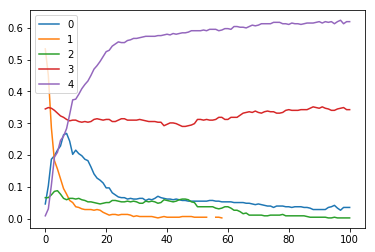

In [17]:
scm.proportions.plot()

Cadre 4 (purple) is the largest cadre and contains around 60% of the training data. Cadres 0 (blue) and 2 (green) are much smaller. Cadre 1 (orange) is the smallest and disappears around halfway through the training process.

The `predictFull` method now also calculates the loss value for the supplied data as the last argument.

In [18]:
margin, label, cadre_weight, cadre, loss = scm.predictFull(Dva)

The `binaryCadreModel` now has a new method, `scoreMetrics`, that returns a one-row `pd.DataFrame` of evaluated metric values.

In [19]:
scm.scoreMetrics(Dva)

,PR_AUC,ROC_AUC,accuracy,loss
0,0.998018,0.996362,0.973684,0.186633
